# The Problem

<font color='#005b96'>
We're in the middle of world wide disaster because of COVID19,<br>
One of the best proven ways to prevent the virus from being publicly spread is to wear masks.<br>
However, not everyone being logically always, <br>
Some people decide not to wear a mask, and those, <br>
put all of us in danger.<br>
The purpose of this pseudo system is to detect people with and w/o mask.<br>
And by that help all of us return to normal life ASAP :)

# Consts

In [1]:
import os

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from IPython.display import Image as DisplayImage
from tqdm.notebook import tqdm

In [2]:
from pathlib import Path

IS_COLAB = False
base_dir = Path('/content/drive/My Drive/Colab Notebooks/Mask Detector') if IS_COLAB else Path('.')
models_dir = base_dir / 'models'
resnet_model_dir = models_dir / 'resnet'
haarcascade_model_dir = models_dir / 'haarcascade'
datasets_dir = base_dir / 'datasets'
videos_dir = base_dir / 'videos'
images_dir = base_dir / 'images'
rmfd_dataset_dir = datasets_dir / 'self-built-masked-face-recognition-dataset'
imgs_w_mask = rmfd_dataset_dir / 'AFDB_masked_face_dataset'
imgs_wo_mask = rmfd_dataset_dir / 'AFDB_face_dataset'
ALREADY_TRAINED = True
device = 'cpu'
seed = 0

In [3]:
np.random.seed(seed)

In [4]:
if IS_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

# Prepare the data

In [5]:
if ALREADY_TRAINED:
    from torchvision.models import resnet18
    
    BEST_MODEL_PATH = Path(resnet_model_dir / 'model_new_2')
    df = pd.read_csv(rmfd_dataset_dir / Path('ds.csv'))
    model = resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.load_state_dict(torch.load(str(base_dir / BEST_MODEL_PATH), map_location=torch.device(device)))

In [6]:
import os
from collections import Counter

if not ALREADY_TRAINED:
    w_mask_imgs_path_list, wo_mask_imgs_path_list = [], []
    w_mask_cnt = Counter()
    wo_mask_cnt = Counter()

    for img_path in imgs_w_mask.rglob('*'):
        if '.' in img_path.name and os.path.isfile(img_path):
            w_mask_imgs_path_list.append(img_path)
            w_mask_cnt.update([img_path.name.split('.')[-1]])
        
    for img_path in imgs_wo_mask.rglob('*'):
        if '.' in img_path.name and os.path.isfile(img_path):
            wo_mask_imgs_path_list.append(img_path)
            wo_mask_cnt.update([img_path.name.split('.')[-1]])

In [ ]:
# Top files extentions
if not ALREADY_TRAINED:
    print(f'Masked images extentions\'s counter: {w_mask_cnt.most_common()}')
    print(f'W/O mask images extentions\'s counter: {wo_mask_cnt.most_common()}')

Masked images extentions's counter: [('jpg', 2118), ('png', 65), ('jpeg', 17), ('JPEG', 3)]
W/O mask images extentions's counter: [('jpg', 90468)]


In [20]:
# Great so let's store the path to the images at DataFrame
if not ALREADY_TRAINED:
    # Adding masked images
    df = pd.DataFrame(zip(w_mask_imgs_path_list, len(w_mask_imgs_path_list)*[1]), columns=['img_path', 'label'])
    # Adding images withous mask
    df = df.append(pd.DataFrame(zip(wo_mask_imgs_path_list, len(wo_mask_imgs_path_list)*[0]), columns=['img_path', 'label']))
    df.reset_index(inplace=True, drop=True)
    df.head(2), df.tail(2)

(                                            img_path  label
 0  /content/drive/My Drive/Colab Notebooks/Mask D...      1
 1  /content/drive/My Drive/Colab Notebooks/Mask D...      1,
                                                 img_path  label
 92669  /content/drive/My Drive/Colab Notebooks/Mask D...      0
 92670  /content/drive/My Drive/Colab Notebooks/Mask D...      0)

In [7]:
df.shape

(92671, 2)

# EDA

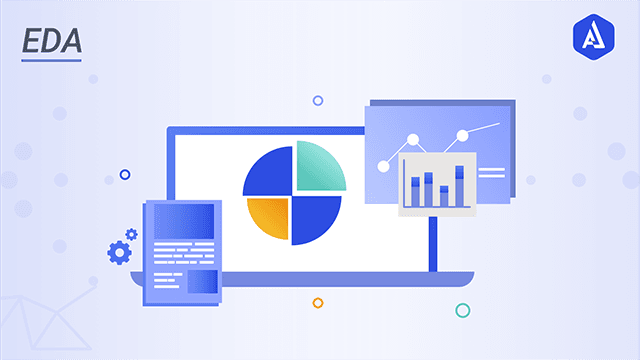

In [8]:
DisplayImage(images_dir / 'eda.png', width=700)

In [9]:
df

,img_path,label
0,datasets/self-built-masked-face-recognition-da...,1
1,datasets/self-built-masked-face-recognition-da...,1
2,datasets/self-built-masked-face-recognition-da...,1
3,datasets/self-built-masked-face-recognition-da...,1
4,datasets/self-built-masked-face-recognition-da...,1
...,...,...
92666,datasets/self-built-masked-face-recognition-da...,0
92667,datasets/self-built-masked-face-recognition-da...,0
92668,datasets/self-built-masked-face-recognition-da...,0
92669,datasets/self-built-masked-face-recognition-da...,0


<font color='#005b96'>
Let's have a look on the classes distribution

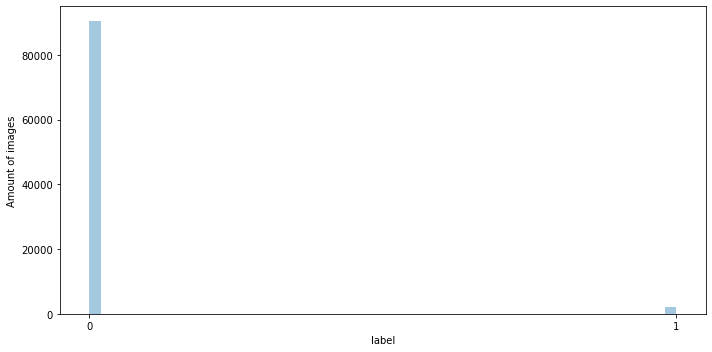

In [10]:
plt.figure(figsize=(10,5))

sns.distplot(df['label'], kde=False)
plt.xticks([0,1])
plt.ylabel('Amount of images')
plt.tight_layout()

In [11]:
print(f"The total amount of images of people without mask is: {df.groupby(['label']).count().iloc[0].item()}")
print(f"The total amount of images of people with mask is: {df.groupby(['label']).count().iloc[1].item()}")
print(f'The total amount of images is: {df.count()[-1]}')

The total amount of images of people without mask is: 90468
The total amount of images of people with mask is: 2203
The total amount of images is: 92671


<font color='#005b96'>
As we can see there is a huge imbalance between the classes,<br>
It means that there is a lot more images of people without a mask.

<font color='#005b96'>
Let's have a look at the images

In [12]:
def plot_image_from_dataset(dataset, index_list, predict=True, model=None):
    import warnings
    warnings.filterwarnings(action='ignore')
    font = {'family' : 'normal',
            'weight' : 'bold',
            'size'   : 22}

    plt.rc('font', **font)
    plt.figure(figsize=(10,10))
    for i, ds_index in enumerate(index_list):
        plt.subplot(22*10+i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(np.array(dataset[ds_index][0].permute(1,2,0)))
        
        if predict:
            model.eval()
            str_ =  r'Does image %d contains a mask? %s'
            predction = model(torch.unsqueeze(dataset[ds_index][0], dim=0))
            prediction_as_bool = predction.item()>0
            plt.annotate(str(prediction_as_bool), (0,0), bbox=dict(boxstyle ="round", fc ="0.8"))
            print(str_ %(i, str(predction.item()>0)))
            print(f'Model certainty {(F.sigmoid(predction).item())}')

    plt.tight_layout();

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


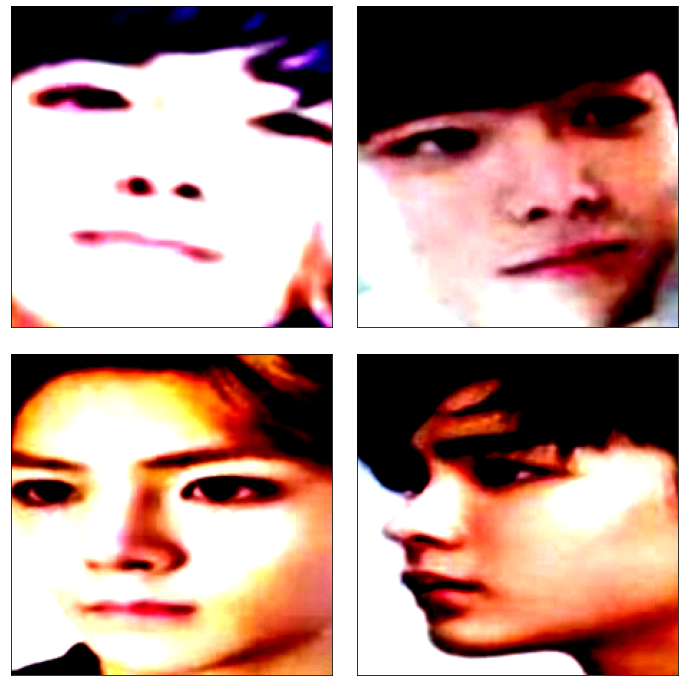

In [ ]:
plot_image_from_dataset(val_dataset, [1227, 1228, 1229, 1230], False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


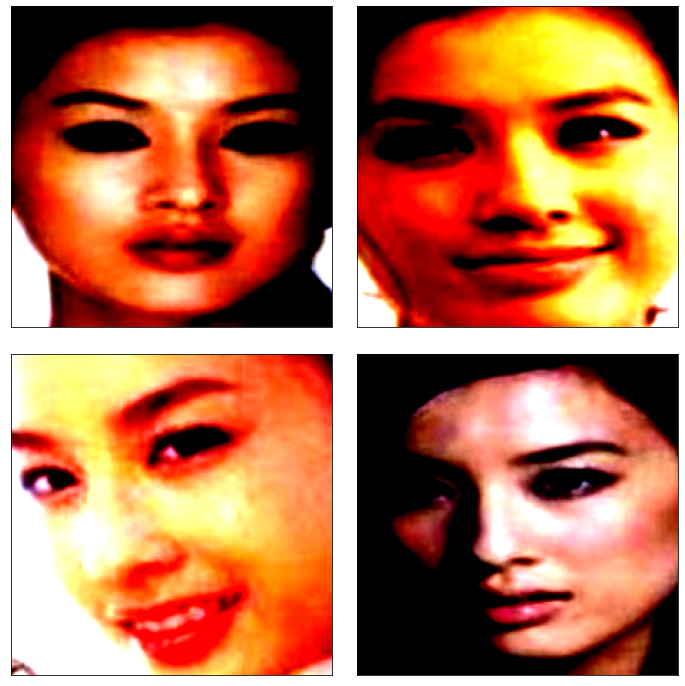

In [ ]:
plot_image_from_dataset(val_dataset, [10,11,12,13], False)

<font color='#005b96'>
After reviewing the images it seems like they already quiet diverse,<br>
So i'll go easy with the transformation and only flip the images horizontally and crop.

# Modeling

<font color='#005b96'>
I'll use transfer learning instead of training a network from scratch.<br>
This way i don't have to have a huge dataset and learn the low level features.<br>
My dataset is medium sized, it consists of 100K images.<br>
I chose to fine-tune resnet18 for this task from three main reasons.<br>
The first one is that i read the paper of resnet and feeling kind of comfortable to modify the backbone of the network if i'll need to.<br>
Secondly, this network is kind of small compared to other networks that were created for classification tasks.<br>
Thirdly, it presented SOTA results on ImageNet and pytorch easily gives me the wieghts of the network after it was trained on ImageNet for classify between 512(specifically resnet18) classes.

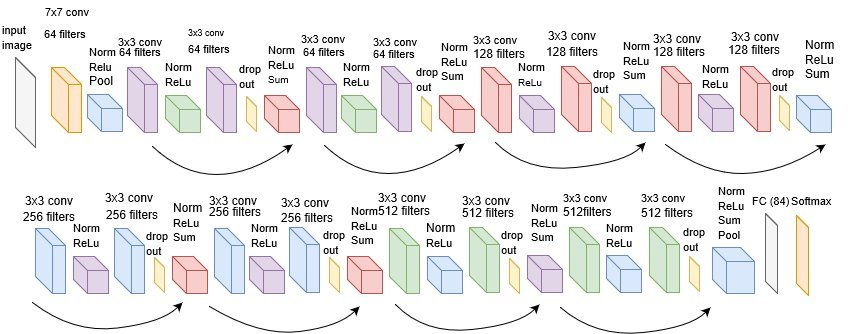

In [13]:
from IPython.display import Image as DisplayImage

DisplayImage(images_dir / 'resnet18.png')

In [14]:
class MaskDataset(Dataset):
    def __init__(self, df, transformers=None):
        super().__init__()
        self.df = df
        self.transformers = transformers
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img = Image.open(str(self.df.loc[idx,'img_path']))
        label = self.df.loc[idx,'label']
        if self.transformers:
            img = self.transformers(img)
        return img, torch.tensor(label, dtype=torch.float64)

In [15]:
from collections import defaultdict


INPUT_SIZE = 224
def get_transform(dataset_type):
    data_transforms = {
        'train': T.Compose([
            T.RandomResizedCrop(INPUT_SIZE),
            T.RandomHorizontalFlip(),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': T.Compose([
            T.Resize(INPUT_SIZE),
            T.CenterCrop(INPUT_SIZE),
            T.ToTensor(),
            T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }
    dd = defaultdict(lambda: data_transforms['train'])
    dd.update(data_transforms)
    return dd[dataset_type]

In [16]:
from functools import partial

train_transform = partial(get_transform, 'train')
val_transform = partial(get_transform, 'val')

<font color='#005b96'>
Because i barelly have images of people with mask,<br>
It's really important that the train and the validation has the same percentage of images with masks.<br>
Otherwise it's really likely that the validation will only contains images w/o mask.<br>
And the validation metrics won't be reliable.

In [17]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=seed)
train_set.reset_index(inplace=True, drop=True)
test_set.reset_index(inplace=True, drop=True)
train_set.shape, test_set.shape

((74136, 2), (18535, 2))

In [18]:
train_set['label'].sum()/train_set['label'].size, test_set['label'].sum()/test_set['label'].size

(0.023767130678752562, 0.023792824386296197)

<font color='#005b96'>
Excellent the train & validation actually have the same frequency of mask and w/o mask

In [19]:
from sklearn.model_selection import train_test_split

dataloaders = {}

train_size = int(len(df)*0.80) 
train_dataset = MaskDataset(train_set, train_transform())
val_dataset = MaskDataset(test_set, val_transform())

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=False)
dataloaders['train'], dataloaders['val'] = train_data_loader, val_data_loader

In [ ]:
if not ALREADY_TRAINED:
    from torchvision.models.resnet import resnet18

    model = resnet18(pretrained=True)
    model.fc

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


<font color='#005b96'>
As we can see the last layer has 512 classes.<br>
While we have only two.<br>
I can create 2 neurons at the last layer and then to use CrossEntropyLoss.<br>
But, PyTorch has nice Loss function for binary classification,<br>                                                                 called, BCELoss, but i won't use it either.<br>
I have two classes and i want the model to predict for each input image the probability of being part of each class,<br>
I can achive it by several ways.<br>
The straight forward one is to apply some function,<br>
    which transorm the values of the last layer from the range [-inf, +inf] to the range [0,1]<br>
    That way i can get ,p, the probability for one class.<br>
    And the probability for the other is just 1-p.<br>
    But wait!<br>
    I know such a function that doing exactly this, the Sigmoid come to rescue!<br>
    So.....<br>
    Why not to apply Sigmoid to the output of the last layer and then just BCELoss?<br>
    From numerical reasons! #NumericalAnalysis1Rocks!<br>
    It's actually very common to apply Logarithim to the standard cross-entropy function.<br>
    The Log has the charachteristic of being a monotonic function which keeps the relationship between each class prediction the same.<br>
    And better than that, now we have the LogLoss function which consists of summation instead of multiplication.<br>
    The summation is numerically more stable, and because that 0 < p < 1 the |Log| is pretty large also, which is more robust.<br>

In [ ]:
# As i sayed it's binary classification i can use only one output neuron.
if not ALREADY_TRAINED:
    model.fc = nn.Linear(model.fc.in_features, 1)
    model.fc

In [20]:
import time
import copy

from collections import defaultdict
from sklearn.metrics import roc_auc_score


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history = []

    val_stats = defaultdict(defaultdict)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        y, y_score = [], []

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    #   In train mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(torch.flatten(outputs), labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        y += torch.flatten(labels.detach()).tolist()
                        y_score += torch.flatten(outputs.detach()).tolist()
                        val_stats[epoch]['y'] = y
                        val_stats[epoch]['y_score'] = y_score
                        

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (torch.flatten(outputs>0) ==  labels).sum().item()
            
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            torch.save(model.state_dict(), f'{str(base_dir)}/model_new_{epoch}')
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60)) 
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_stats

<font color='#005b96'>
Regarding the training process.<br>
    I'd to train on GPU such a network.<br>
    I used Google Colab for this task.<br>
    First of all i tried to train the network with batch size of 128 because i thought that it'll be the best size with respect for the amount of samples i've.<br>
    But the training process took more then 12 hours for one epoch on K80 at Colab.<br>
    I noticed that i have some extra RAM available on Colab so i just increased the batch size to 256.<br>
    That way the training of the first epoch took me ~6 hours.<br>
    Google colab does'nt gaurentee that you'll have the GPU available all the time.<br>
    In fact, it gaurentees that you'll be kicked out if you're using Colab's notebook for more then 12h.<br>
    I was kicked out tens of times during the training and the validation process but eventually i nailed it.<br>
For furthere research i collected statistics during that process.


In [ ]:
if not ALREADY_TRAINED:
    # Setup the loss function
    criterion = nn.BCEWithLogitsLoss()

    # Let's add Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999),
                                 eps=1e-08, weight_decay=0, amsgrad=False)

    num_epochs = 5
    model.to(device)
    # Train and evaluate
    model, val_acc_history, val_stats = train_model(model, dataloaders, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/4
----------



train Loss: 0.0410 Acc: 0.9860



val Loss: 0.0048 Acc: 0.9987

Epoch 1/4
----------



train Loss: 0.0169 Acc: 0.9950



val Loss: 0.0082 Acc: 0.9979

Epoch 2/4
----------



train Loss: 0.0155 Acc: 0.9954



val Loss: 0.0072 Acc: 0.9975

Epoch 3/4
----------



train Loss: 0.0123 Acc: 0.9960



val Loss: 0.0052 Acc: 0.9982

Epoch 4/4
----------



train Loss: 0.0112 Acc: 0.9966



val Loss: 0.0057 Acc: 0.9983

Training complete in 555m 55s
Best val Acc: 0.998651


<font color='#005b96'>
Intresting!<br>
The first model got the highest Accuracy score on the validation set.
Is it saying that this is the best model?<br><br>
Absolutly not!<br><br>
Because of the huge imabalance between the classes Accuracy may not be the best metric.<br>
Think about a dummy model which always predict "No Mask",<br>
That model has Accuracy of 0.976 !<br>
This is why i bothered to collect more stats, because i have better metircs to examine how well each model have done.


In [21]:
print(f"Accuracy of dummy model which always predicts No mask, with 3 significant digits and round is: {np.round(float(df.groupby(['label']).count().loc[0,:] / df.groupby(['label']).count().sum()), 3)}")

Accuracy of dummy model which always predicts No mask, with 3 significant digits and round is: 0.976


In [24]:
import pickle

if not ALREADY_TRAINED:
    with open(resnet_model_dir / 'val_stats', 'wb') as fp:
        pickle.dump(val_stats, fp)
else:
    with open(resnet_model_dir / 'val_stats', 'rb') as fp:
        val_stats = pickle.load(fp)

In [25]:
if not ALREADY_TRAINED:
    with open(resnet_model_dir / 'val_acc_history', 'wb') as fp:
        pickle.dump(val_acc_history, fp)
else:
    with open(resnet_model_dir / 'val_acc_history', 'rb') as fp:
        val_acc_history = pickle.load(fp)

<font color='#005b96'>
    <h2>Area under the Curve</h2>

<font color='#005b96'>
Area Under the ROC Curve could be a great metric because it takes into account the prior of each distribution.<br>
The ROC curve is build by calculating for a lot of thresholds between zero and one, the corresponding False Positive Rate as the X-axis and the True Positive Rate(Recall) as the Y-Axis.
And the AUC is just the integral of this curve between 0 and 1.<br>
That way we get a single number which represent how good the model perform.

In [27]:
from sklearn.metrics import roc_auc_score

auc_list = []
for epoch, stats in val_stats.items():
    y = stats['y']
    y_score = stats['y_score']
    auc = roc_auc_score(y, torch.sigmoid(torch.tensor(y_score)))
    auc_list.append(auc)
    print(f'Epoch {epoch} - Area under ROC curve: {auc}')
    print()

Epoch 0 - Area under ROC curve: 0.9997483537094142

Epoch 1 - Area under ROC curve: 0.9987596895727452

Epoch 2 - Area under ROC curve: 0.9998156515470857

Epoch 3 - Area under ROC curve: 0.9996197734832484

Epoch 4 - Area under ROC curve: 0.9995781666264384



<font color='#005b96'>
We can also see those results in a nice plot.

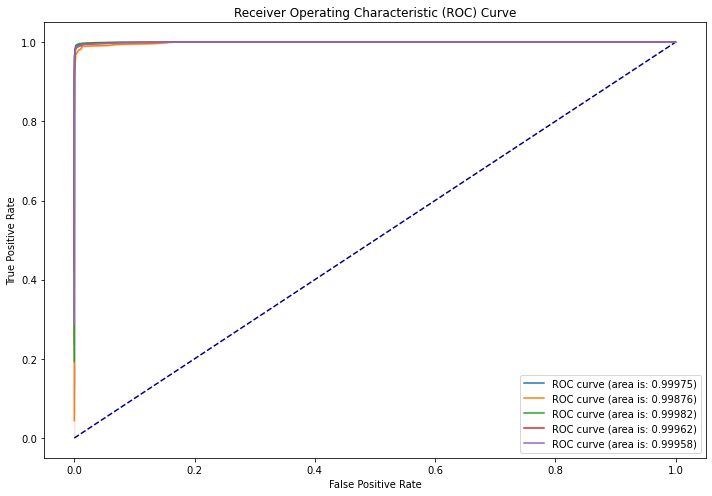

In [28]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

for epoch, stats in val_stats.items():
    fpr, tpr, thresh = roc_curve(stats['y'], stats['y_score'])          
    df = pd.DataFrame(list(zip(fpr, tpr)), columns=['False Positive Rate', 'True Positive Rate'])
    sns.lineplot(x='False Positive Rate', y='True Positive Rate', data=df,
                label=f'ROC curve (area is: {round(auc(fpr, tpr), 5)})', estimator='mean')
plt.tight_layout()        

<font color='#005b96'>
Because of the minor difference between the results, we could have a look at the log scale.

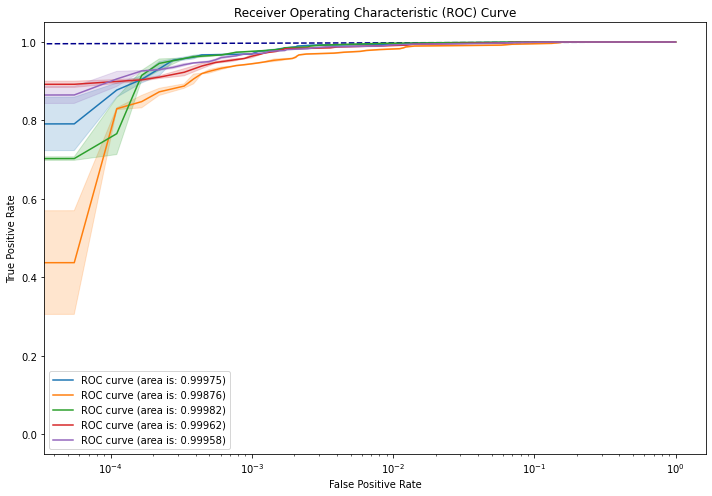

In [29]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10,7))
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')

for epoch, stats in val_stats.items():
    fpr, tpr, thresh = roc_curve(stats['y'], stats['y_score'])          
    df = pd.DataFrame(list(zip(fpr, tpr)), columns=['False Positive Rate', 'True Positive Rate'])
    ax = sns.lineplot(x='False Positive Rate', y='True Positive Rate', data=df,
                label=f'ROC curve (area is: {round(auc(fpr, tpr), 5)})', estimator='mean')
    ax.set(xscale="log")
plt.tight_layout()        

<h2>Other metrics</h2>

*   True Positive Rate or recall:<br>
The percentage of masked images that were detected to all masked images.<br>
$$
TPR = TP / (TP+FN)
$$
*   False Positive Rate:<br>
The percentage of images w/o mask that detected as images with mask to all the unmasked images.<br>
$$
FPR = FP / (FP+TN)
$$


*   Precision:<br>
The percentage of masked images that were detected to all the images that were reported as masked images.<br>
$$
Precision = TP / (TP+FP)
$$


*   F1-Score:<br>
If we'll set the classification threshold to 0.00001, the recall would be close to 1(100%),<br>
Because we'll report almost each and every image as masked.<br>
And if we'll set the classification threshold to 0.99999, the precision would be close to 1(100%),<br>
Because we'll report almost each and every image as unmasked.<br>
So we have a motivation to some how "balance" between the two.<br>
And F1-Score is exactlly this.<br>
$$
F1 = 2 * Recall * Precision/(Recall+Precision)
$$


In [30]:
from sklearn.metrics import confusion_matrix

for epoch, stats in val_stats.items():
    y = stats['y']
    y_score = stats['y_score']
    tn, fp, fn, tp = confusion_matrix(y, [round(i.item()) for i in torch.sigmoid(torch.tensor(y_score))]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    f1 = 2*precision*tpr / (precision+tpr)
    print(f'Epoch {epoch} - True Positive Rate: {tpr}')
    print(f'Epoch {epoch} - False Positive Rate: {fpr}')
    print(f'Epoch {epoch} - Precision: {precision}')
    print(f'Epoch {epoch} - F1 score: {f1}')
    print()

Epoch 0 - True Positive Rate: 0.9569160997732427
Epoch 0 - False Positive Rate: 0.0003316016359014038
Epoch 0 - Precision: 0.985981308411215
Epoch 0 - F1 score: 0.9712313003452245

Epoch 1 - True Positive Rate: 0.9365079365079365
Epoch 1 - False Positive Rate: 0.000607936332485907
Epoch 1 - Precision: 0.9740566037735849
Epoch 1 - F1 score: 0.9549132947976878

Epoch 2 - True Positive Rate: 0.9863945578231292
Epoch 2 - False Positive Rate: 0.0022659445119929257
Epoch 2 - Precision: 0.9138655462184874
Epoch 2 - F1 score: 0.9487459105779716

Epoch 3 - True Positive Rate: 0.9569160997732427
Epoch 3 - False Positive Rate: 0.0007737371504366088
Epoch 3 - Precision: 0.9678899082568807
Epoch 3 - F1 score: 0.9623717217787913

Epoch 4 - True Positive Rate: 0.9387755102040817
Epoch 4 - False Positive Rate: 0.0002763346965845032
Epoch 4 - Precision: 0.9880668257756563
Epoch 4 - F1 score: 0.9627906976744187



<font color='#005b96'>
If i need to pick up the best model out of those four.<br>
I'm picking model no 2.<br>
There is no one good answer and the best model could vary by choosing different metrics.<br>
But as I explaied before, the AUC is one of the best metrics for this detection task.<br>
Furtheremore,<br>
Model 2 got the highest TPR which is also called, detection rate,<br>
It means that from all the pictures of people with masks,<br>
Model no 2 detect the most of them correctlly in compare to the others.<br>

In [31]:
stats_df = pd.DataFrame()

for epoch, stats in val_stats.items():
    y = stats['y']
    y_score = stats['y_score']
    tn, fp, fn, tp = confusion_matrix(y, [round(i.item()) for i in torch.sigmoid(torch.tensor(y_score))]).ravel()
    tpr = tp / (tp + fn)
    fpr = fp / (fp + tn)
    precision = tp / (tp + fp)
    f1 = 2*precision*tpr / (precision+tpr)
    stats_df.loc[epoch, 'tpr'] = tpr
    stats_df.loc[epoch, 'fpr'] = fpr
    stats_df.loc[epoch, 'precision'] = precision
    stats_df.loc[epoch, 'f1'] = f1
    stats_df.loc[epoch, 'auc'] = auc_list[epoch]

stats_df

,tpr,fpr,precision,f1,auc
0,0.956916,0.000332,0.985981,0.971231,0.999748
1,0.936508,0.000608,0.974057,0.954913,0.998760
2,0.986395,0.002266,0.913866,0.948746,0.999816
3,0.956916,0.000774,0.967890,0.962372,0.999620
4,0.938776,0.000276,0.988067,0.962791,0.999578


<font color='#005b96'>
Let's have a look at the validation stats

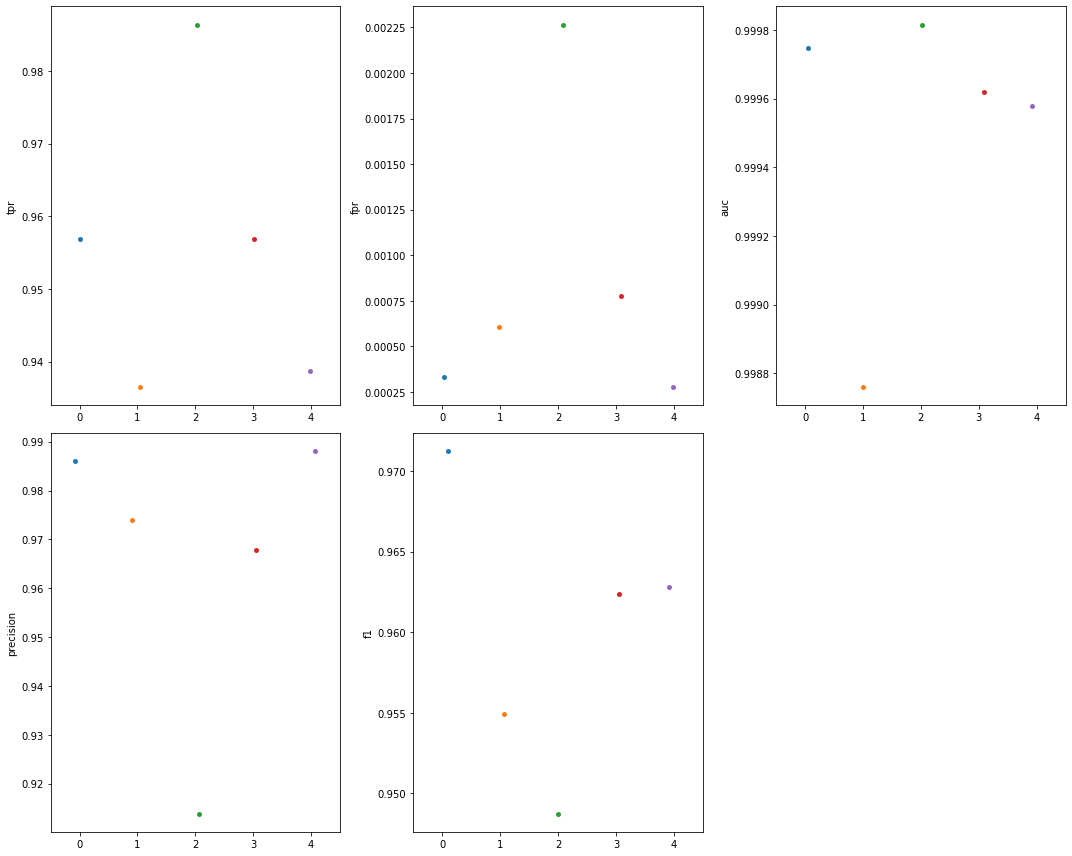

In [32]:
EVAL_METRICS = ['tpr', 'fpr', 'auc', 'precision', 'f1']

plt.figure(figsize=(15, 12))
for i, metric in enumerate(EVAL_METRICS, start=1):
    plt.subplot(230 + i)
    sns.stripplot(x=stats_df.index, y=stats_df[metric])
plt.tight_layout()

# Evaluation

<font color='#005b96'>
    <h2>Good examples</h2>

<font color='#005b96'>
    <h3>True Positive</h3>

In [33]:
model.eval();

In [34]:
idx_of_tp_samples_list = []

for i, row in val_dataset.df[val_dataset.df['label'] == 1].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p > 0.5:
        idx_of_tp_samples_list.append(i)
    if len(idx_of_tp_samples_list) >= 4:
        break
idx_of_tp_samples_list

[9, 79, 88, 109]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? True
Model certainty 0.9999961853027344
Does image 1 contains a mask? True
Model certainty 0.998664379119873
Does image 2 contains a mask? True
Model certainty 0.9999051094055176


findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


Does image 3 contains a mask? True
Model certainty 0.9999961853027344


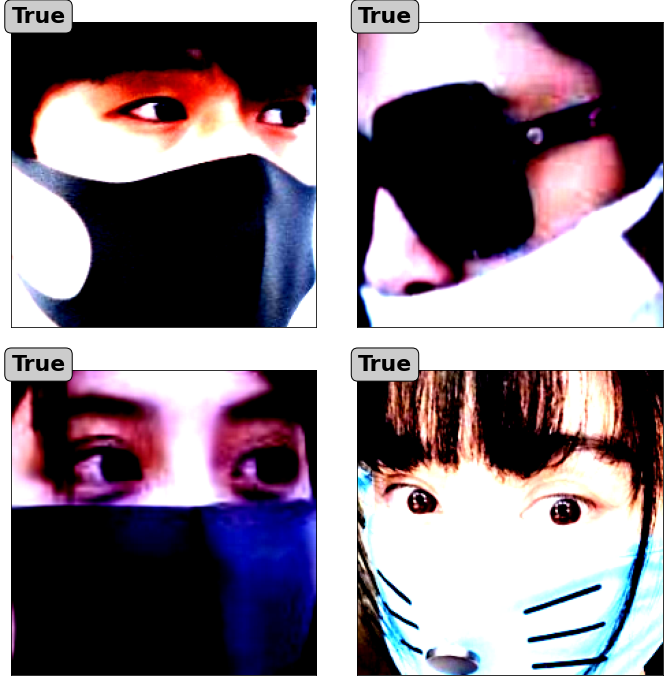

In [35]:
plot_image_from_dataset(val_dataset, idx_of_tp_samples_list, predict=True, model=model)

<font color='#005b96'>
The fourth image is very intresting, the mask isn't stadrad and it looks like cat mustache, it could of, but didn't fool our model.

<font color='#005b96'>
    <h3>True Negative</h3> 

In [61]:
idx_of_tn_samples_list = []

model.eval()
for i, row in val_dataset.df[val_dataset.df['label'] == 0].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p <= 0.5:
        idx_of_tn_samples_list.append(i)
    if len(idx_of_tn_samples_list) >= 4:
        break
idx_of_tn_samples_list

[0, 1, 2, 3]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? False
Model certainty 0.00016113244055304676
Does image 1 contains a mask? False
Model certainty 3.322800694149919e-05
Does image 2 contains a mask? False
Model certainty 0.003376559354364872
Does image 3 contains a mask? False
Model certainty 3.368639954715036e-05


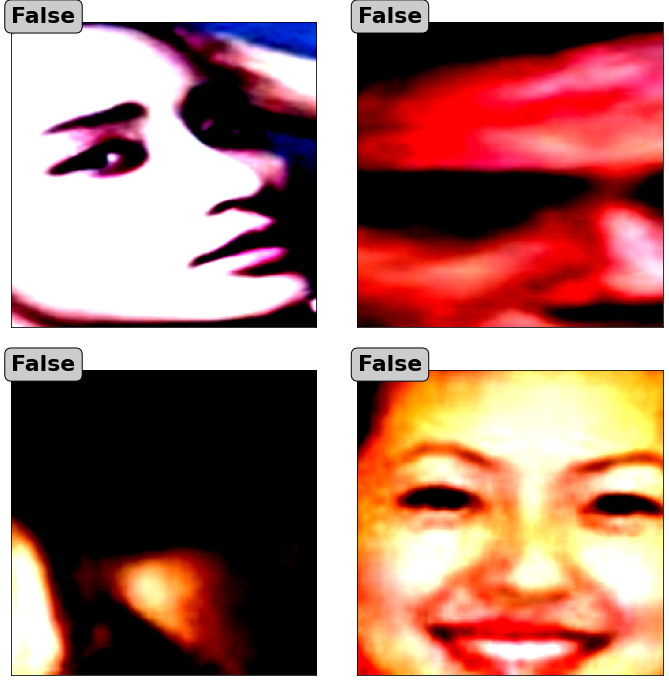

In [64]:
plot_image_from_dataset(train_dataset, idx_of_tn_samples_list, predict=True, model=model)

<font color='#005b96'>
I don't really see what's going on at the third image,<br>
it looks like an eye maybe, anyway it's not a mask for sure.

<h1>Bad example</h1>

<h1>False Positive</h1>

In [18]:
idx_of_fp_samples_list = []

model.eval()
for i, row in val_dataset.df[val_dataset.df['label'] == 0].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p > 0.5:
        idx_of_fp_samples_list.append(i)
    if len(idx_of_fp_samples_list) >= 4:
        break
idx_of_fp_samples_list

[1017, 1291, 1618, 2982]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? True
Model certainty 0.5526717901229858
Does image 1 contains a mask? True
Model certainty 0.6444490551948547


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 2 contains a mask? True
Model certainty 0.8335019946098328
Does image 3 contains a mask? True
Model certainty 0.5472682118415833


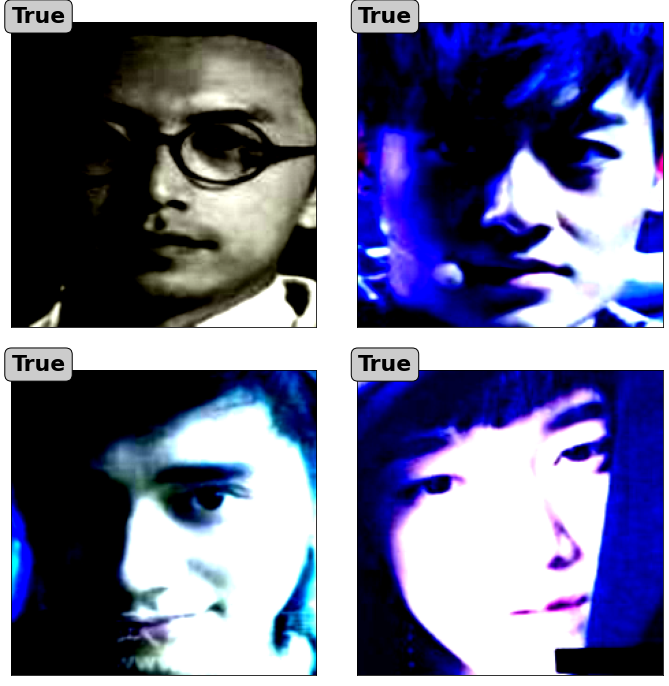

In [22]:
plot_image_from_dataset(val_dataset, idx_of_fp_samples_list, predict=True, model=model)

<h2>False Negative</h2>

In [23]:
idx_of_fn_samples_list = []

model.eval()
for i, row in val_dataset.df[val_dataset.df['label'] == 1].iterrows():
    p = torch.sigmoid(model(val_dataset[i][0].unsqueeze(0)).to(device)).item()
    if p <= 0.5:
        idx_of_fn_samples_list.append(i)
    if len(idx_of_fn_samples_list) >= 4:
        break
idx_of_fn_samples_list

[1035, 1142, 2525, 4153]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 0 contains a mask? False
Model certainty 0.35560184717178345
Does image 1 contains a mask? False
Model certainty 0.0017638617428019643


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Does image 2 contains a mask? False
Model certainty 0.37435123324394226
Does image 3 contains a mask? False
Model certainty 0.20696043968200684


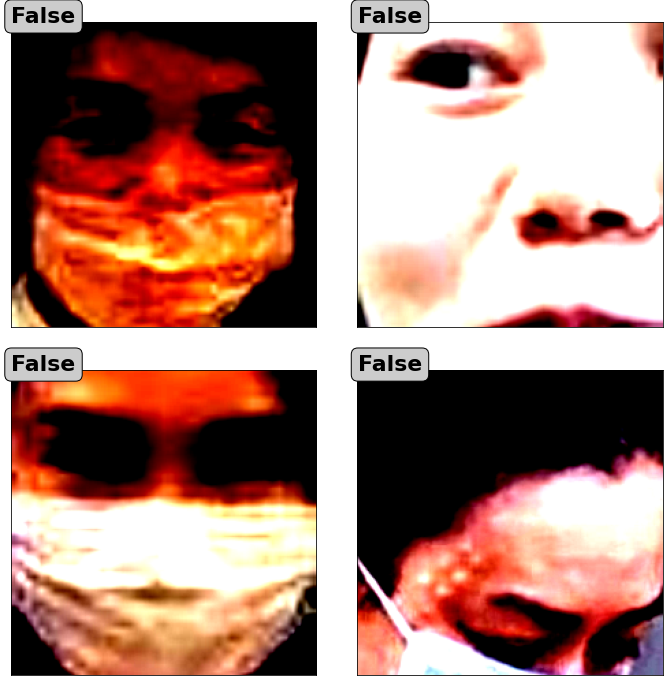

In [24]:
plot_image_from_dataset(val_dataset, idx_of_fn_samples_list, predict=True, model=model)

<font color='#005b96'>
By looking at the second image we can conclude that there was wrong labeling for sure,<br>
Actually the model was correct and the annotater was wrong :)<br>
So the second image sould be TN.<br>
It's questioning the entire labeling mechanism, whether it was done correctly.

<h1>Live Video</h1>

<font color='#005b96'>
The next step is to apply our model on videos.<br>
How would we perform it?<br>
A video is just a bunch of frames, AKA, images.<br>
So, we could just run a face detector that will detect faces, crop them, and feedforward those to our model.<br>
For the face detection task and the video processing i used opencv pretrained model and additional tools the package providing out of the box.<br>
Let's go!<br>
As soon as you run the next cell, your video camera will become active and the mask detector will start to classify you!

In [ ]:
import numpy as np
import cv2


cap = cv2.VideoCapture(0)

# Load the cascade
face_cascade = cv2.CascadeClassifier(str(haarcascade_model_dir / 'haarcascade_frontalface_default.xml'))


labelColor = {'No Mask': (10, 0, 255), 'Has Mask': (10, 255, 0)}

model.eval()
while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    # Our operations on the frame come here
    image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    for face in face_cascade.detectMultiScale(image, 1.05, 5):
        xStart, yStart, width, height = face
        
        # clamp coordinates that are outside of the image
        xStart, yStart = max(xStart, 0), max(yStart, 0)

        cropped_face = image[yStart:yStart+height, xStart:xStart+width]
        
        img = val_transform()(Image.fromarray(cropped_face).convert('RGB'))

        output = model(img.unsqueeze(0).to(device))
        
        label = 'Has Mask' if output.item() > 0 else 'No Mask'
           
        cv2.rectangle(frame,
                      (xStart, yStart),
                      (xStart + width, yStart + height),
                      (126, 65, 64),
                      thickness=2)
        
        
        # center text according to the face frame
        textSize = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1, 2)[0]
        textX = xStart + width // 2 - textSize[0] // 2

        # draw prediction label
        cv2.putText(frame,
                    label,
                    (textX, yStart-20),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, labelColor[label], 2)
    
    cv2.imshow('video', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()

<font color='#005b96'>
And here is a short video of me being classified by the model.

In [67]:
from IPython.display import Video

Video(videos_dir / "mask_detector.mp4")

<h1>Next steps</h1>

If i had more compute resources i would try the next steps:<br>
* Examine other models like: EfficientNet, VGG, GoogLeNet, YOLO.
* Search for more / better data and even annotate myself, the given images don't have the best quality.
* Optimize the hyperparameters, for instanse trying SGD + Momentum instead of Adam optimizer, changing the batch size and so on and so forth.
* Even considering re-run the whole process again with different initial seed, maybe the network got stucked at local minima.
* Try to overfit, maybe after several epochs of increasing at the validation loss, there will be a significant decreasing(With an appropriate LR that could assist me getting out of those local minimas). 